In [4]:
from graph import Graph
from itertools import combinations
from tqdm import tqdm
from time import perf_counter

Какая есть функциональность. 

1) можем добавлять вершины
2) добавлять ребра
3) рисовать получившийся граф

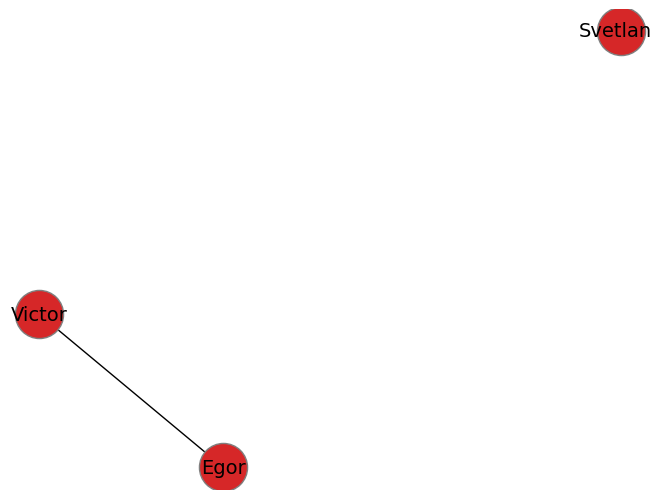

In [6]:
g = Graph()

g.add_node("Victor")
g.add_node("Egor")
g.add_node("Svetlana")

g.add_edge("Victor", "Egor")

g.draw_graph()

Ну и конечно можем делать случайный граф. Только мы должны заранее задать сколько будет вершин у данного графа и вероятность что мы проведем ребро

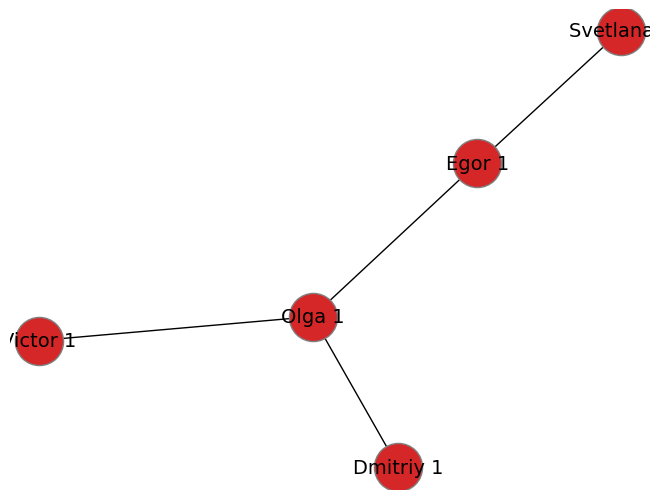

In [9]:
g = Graph.generate_random(5, 0.1)
g.draw_graph()

“Вы выбираете из группы из N друзей, с кем пойти на пикник. Однако друзья, связанные ребром на графе, находятся в очень недружественных отношениях друг с другом, поэтому, если они оба отправятся на пикник, он будет испорчен. Чтобы на пикнике было как можно больше друзей, кого следует пригласить?. Протестируйте алгоритм на случайных графах (5 - 10 штук)  различного размера, отрисуйте случайные графы и выведите финальный список на экран или в фаил.”

Эта проблема известна как задача о максимальном независимом множестве в графе или же нахождение максимальной клики в инвертированном графе. По проведенным мной исследованиям, на сегодняшний день нет эффективного алгоритма решения данной задачи, а сама задача NP-complete. Покуда у нас $P != NP$, то точно решение только переборное.  (в качестве шутки недавняя [статья](https://arxiv.org/abs/2304.12517) на которую я наткнулся, где "доказывают", что $P=NP$). 

В моей реализации предложено два алгоритма


1) Любимый брутфорс. Точное решение, переборное, очень долгое

2) Жадный алгоритм, где мы сортируем вершины согласно их степени и берем сначала вершины с меньшим количеством ребер. 

Если верить [теореме](https://courses.engr.illinois.edu/cs583/sp2018/Notes/packing.pdf), то такое решение $\geq \cfrac{OPT}{\Delta}$, где $\Delta$ - максимальная степень вершины в графе 

In [10]:
def MIS_brute(all_nodes):
    set_size = 0
    best_set = []
    for i in range(len(all_nodes)):
        iter_comb = combinations(all_nodes.keys(), i)
        for comb in iter_comb:
            possible_set = set()
            can_add = True
            for vertex in comb:
                for added_vertex in possible_set:
                    if vertex in all_nodes[added_vertex].neighbors:
                        can_add = False
                        break

                if can_add:
                    possible_set.add(vertex)

            if len(possible_set) > set_size:
                set_size = len(possible_set)
                best_set = [possible_set]
            elif len(possible_set) == set_size:
                if possible_set not in best_set:
                    best_set.append(possible_set)

    return best_set


def MIS_greedy(all_nodes):
    degrees = [(name, len(node.neighbors)) for name, node in all_nodes.items()]
    degrees = sorted(degrees, key=lambda x: x[1])

    possible_set = set()

    for vertex, degree in degrees:
        can_add = True
        for added_vertex in possible_set:
            if vertex in all_nodes[added_vertex].neighbors:
                can_add = False
                break

        if can_add:
            possible_set.add(vertex)

    return possible_set

Запустим и убедимся что все работает

In [11]:
MIS_brute(g.all_nodes)

[{'Dmitriy 1', 'Svetlana 1', 'Victor 1'}, {'Dmitriy 1', 'Egor 1', 'Victor 1'}]

In [12]:
MIS_greedy(g.all_nodes)

{'Dmitriy 1', 'Svetlana 1', 'Victor 1'}

Теперь запустим на нескольких случайных графах и посчитаем алгоритм для каждого. Картинка получается достаточно большая, поэтому я сделаю немного, а анализ будет далее ниже

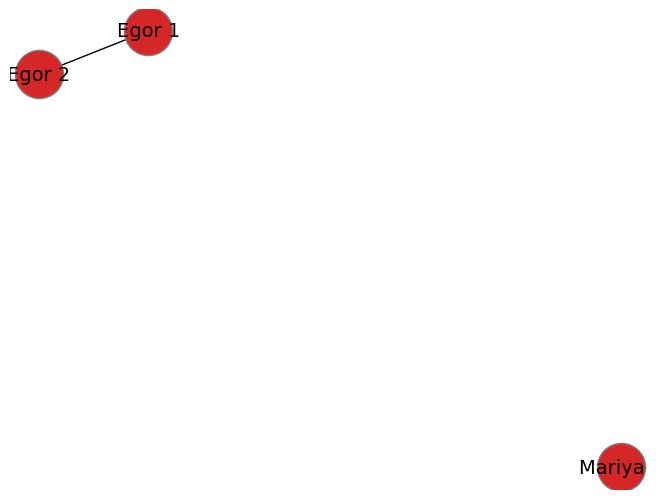

{'Mariya 1', 'Egor 1'}


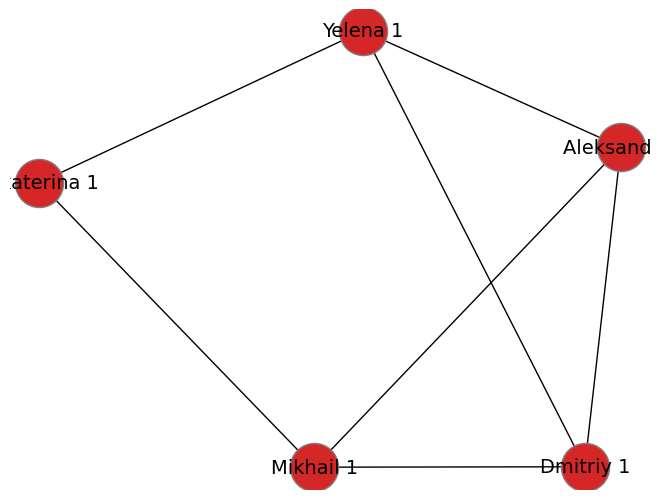

{'Yelena 1', 'Mikhail 1'}


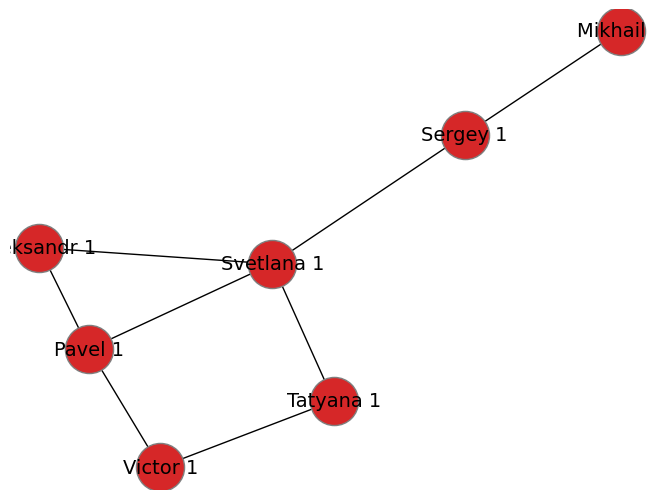

{'Aleksandr 1', 'Tatyana 1', 'Sergey 1'}


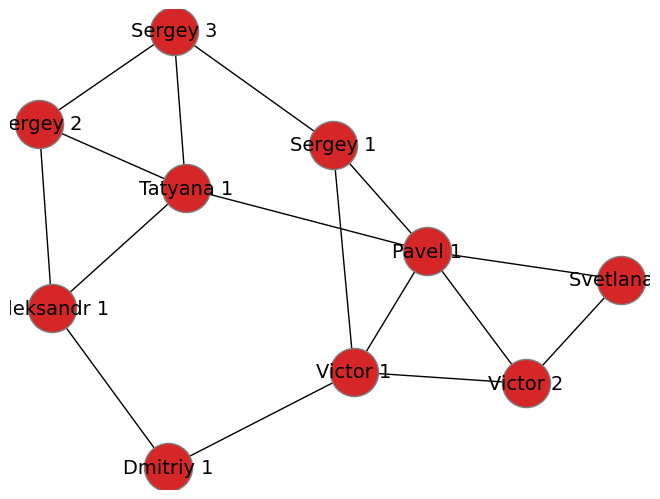

{'Sergey 2', 'Svetlana 1', 'Dmitriy 1', 'Sergey 1'}


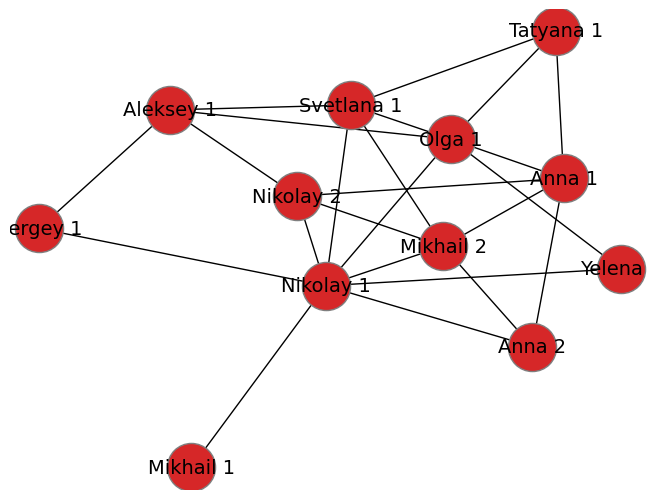

{'Yelena 1', 'Svetlana 1', 'Anna 2', 'Sergey 1', 'Nikolay 2', 'Mikhail 1'}


In [15]:
n_grid = [3, 5, 7, 10, 12]

for n in n_grid:
    g = Graph.generate_random(n, p=0.2)
    g.draw_graph()
    print(MIS_brute(g.all_nodes)[0])

Посмотрим несколько вещей на случайных графах

1. В каком проценте случаев ошибется жадная стратегия в зависимости от вероятности построения ребра и количества вершин.

2. Как растет время в зависимости от количества вершин и вероятности ребра.

In [51]:
p_grid = [0.1, 0.2, 0.4, 0.5, 0.7, 0.9]
repeats = 50
res_p = {}

for p in tqdm(p_grid):
    times = []
    corrects = []
    for i in range(repeats):
        g = Graph.generate_random(15, p)

        start = perf_counter()
        brute_res = MIS_brute(g.all_nodes)
        end = perf_counter()

        greedy_res = MIS_greedy(g.all_nodes)

        correct = 1
        if len(greedy_res) != len(brute_res[0]):
            correct = 0

        times.append(end - start)
        corrects.append(correct)

    res_p[p] = (np.mean(times), np.mean(corrects))

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


In [55]:
n_grid = [5, 7, 10, 15, 20]
repeats = 30
res_n = {}

for n in n_grid:
    times = []
    corrects = []
    for i in tqdm(range(repeats)):
        g = Graph.generate_random(n, 0.2)

        start = perf_counter()
        brute_res = MIS_brute(g.all_nodes)
        end = perf_counter()

        greedy_res = MIS_greedy(g.all_nodes)

        correct = 1
        if len(greedy_res) != len(brute_res[0]):
            correct = 0

        times.append(end - start)
        corrects.append(correct)

    res_n[n] = (np.mean(times), np.mean(corrects))

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:04<00:00,  2.14s/it]


In [57]:
res_n, res_p

({5: (0.00013515990067389794, 1.0),
  7: (0.000533426466305779, 0.9666666666666667),
  10: (0.00202495543283779, 0.8333333333333334),
  15: (0.0531743178665541, 0.6666666666666666),
  20: (2.129571920800178, 0.6)},
 {0.1: (0.05871024858002784, 0.76),
  0.2: (0.046709466359898213, 0.64),
  0.4: (0.0451835602203937, 0.74),
  0.5: (0.044733498280184, 0.78),
  0.7: (0.043629764200231874, 0.96),
  0.9: (0.044943192440041455, 1.0)})

Видим что по мере увеличения вершин наш алгоритм "в лоб" начинает работать сильно дольше, и в то же время жадный алгоритм начинает чаще ошибаться. С вероятностью наблюдается только уменьшение ошибки с увеличением вероятности. 